In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
df_trades = pd.read_csv('../data/round5/trades_combined_r5.csv', delimiter=';')
print(df_trades.head())

   day  timestamp    buyer   seller            symbol   currency   price  \
0    1          0   Caesar    Paris        CROISSANTS  SEASHELLS  4265.0   
1    1        100  Charlie    Paris  RAINFOREST_RESIN  SEASHELLS  9999.0   
2    1        200    Paris   Caesar        CROISSANTS  SEASHELLS  4266.0   
3    1        200    Paris   Caesar              JAMS  SEASHELLS  6520.0   
4    1        200    Paris  Charlie              KELP  SEASHELLS  2046.0   

   quantity  
0         8  
1         1  
2         8  
3         7  
4         1  


In [13]:
print(df_trades["buyer"].unique())
print(df_trades["symbol"].unique())

['Caesar' 'Charlie' 'Paris' 'Camilla' 'Pablo' 'Penelope' 'Gary' 'Peter'
 'Gina' 'Olivia']
['CROISSANTS' 'RAINFOREST_RESIN' 'JAMS' 'KELP' 'SQUID_INK'
 'PICNIC_BASKET1' 'PICNIC_BASKET2' 'MAGNIFICENT_MACARONS' 'DJEMBES'
 'VOLCANIC_ROCK_VOUCHER_10000' 'VOLCANIC_ROCK_VOUCHER_10250'
 'VOLCANIC_ROCK_VOUCHER_10500' 'VOLCANIC_ROCK_VOUCHER_9500'
 'VOLCANIC_ROCK_VOUCHER_9750' 'VOLCANIC_ROCK']


In [18]:
import pandas as pd

# Load matched trade data and order book snapshots (adjust file paths or data sources as needed)
trades = pd.read_csv('../data/round5/trades_combined_r5.csv', delimiter=';')  # columns: timestamp, asset, price, quantity, buyer, seller, etc.
orderbook = pd.read_csv('../data/round5/prices_combined_r5.csv', delimiter=';')  # columns: timestamp, asset, best_bid, best_ask, mid_price, etc.

## rename columns to match



trades = trades.rename(columns={'symbol': 'asset'})
orderbook = orderbook.rename(columns={'product': 'asset'})
trades.sort_values(by=['timestamp', 'asset'], inplace=True)
trades.reset_index(drop=True, inplace=True)
orderbook.sort_values(by=['timestamp', 'asset'], inplace=True)
orderbook.reset_index(drop=True, inplace=True)
# Merge each trade with the nearest past snapshot (order book state at or immediately before the trade)
merged = pd.merge_asof(
    trades, 
    orderbook, 
    on='timestamp', 
    by='asset', 
    direction='backward',  # use the last known orderbook state up to the trade time
    suffixes=('', '_obs')  # avoid suffix issues if overlapping column names
)

# If there’s a chance that a trade happens *exactly* at a snapshot timestamp, 
# you might use direction='nearest' or handle exact matches separately. 
# The assumption here is that 'backward' gives the snapshot at the trade moment.
print("Merged dataset size:", merged.shape)
merged.head(5)  # show a few sample merged rows for verification


Merged dataset size: (53477, 23)


,day,timestamp,buyer,seller,asset,currency,price,quantity,day_obs,bid_price_1,...,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,1,0,Caesar,Paris,CROISSANTS,SEASHELLS,4265.0,8,4,4296.0,...,NaN,NaN,4297.0,41.0,4298.0,95.0,NaN,NaN,4296.5,0.0
1,2,0,Caesar,Paris,CROISSANTS,SEASHELLS,4241.0,8,4,4296.0,...,NaN,NaN,4297.0,41.0,4298.0,95.0,NaN,NaN,4296.5,0.0
2,2,0,Caesar,Paris,JAMS,SEASHELLS,6522.0,6,4,6446.0,...,NaN,NaN,6447.0,95.0,6448.0,177.0,NaN,NaN,6446.5,0.0
3,3,0,Caesar,Paris,JAMS,SEASHELLS,6446.0,10,4,6446.0,...,NaN,NaN,6447.0,95.0,6448.0,177.0,NaN,NaN,6446.5,0.0
4,1,100,Charlie,Paris,RAINFOREST_RESIN,SEASHELLS,9999.0,1,4,9992.0,...,NaN,NaN,10008.0,25.0,NaN,NaN,NaN,NaN,10000.0,0.0


In [28]:
bid_cols = ['bid_price_1','bid_price_2','bid_price_3']
ask_cols = ['ask_price_1','ask_price_2','ask_price_3']


merged['best_bid'] = merged[bid_cols].max(axis=1)
merged['best_ask'] = merged[ask_cols].min(axis=1)

# Determine aggressor side by comparing trade price to best bid/ask
merged['aggressor_side'] = merged.apply(lambda row: 
                                       'BUY' if row['price'] >= row['best_ask'] else 
                                       'SELL' if row['price'] <= row['best_bid'] else 
                                       'UNKNOWN', axis=1)

# Identify the aggressor bot (which trader initiated the trade)
merged['aggressor_bot'] = merged.apply(lambda row: 
                                      row['buyer'] if row['aggressor_side'] == 'BUY' else 
                                      row['seller'] if row['aggressor_side'] == 'SELL' else 
                                      None, axis=1)

# Get the next mid-price after each trade (within the same asset)
# We can use merge_asof again, this time forward-looking to get the next snapshot
next_mid = pd.merge_asof(
    trades, 
    orderbook[['asset','timestamp','mid_price']], 
    on='timestamp', 
    by='asset', 
    direction='forward',  # next snapshot at or after trade time
    suffixes=('', '_next')
)
print(next_mid.head())  
# The merge_asof above will attach the mid_price of the snapshot at or *equal/after* the trade time.
# If it attaches the same timestamp (trade exactly on a snapshot), that is the current mid; 
# better to ensure it's strictly after. One way is to shift within each asset group:
next_mid = next_mid.sort_values(['asset','timestamp'])
next_mid['mid_price_next'] = next_mid.groupby('asset')['mid_price'].shift(-1)
# Now 'mid_price_next' is the mid-price strictly after the trade (the following snapshot).

# Add the next mid price to merged DataFrame by aligning on trade index (since trades order was preserved)
merged['next_mid_price'] = next_mid['mid_price_next'].values

# Classify price impact direction by comparing next mid-price to current mid-price at trade time
def impact_direction(current_mid, next_mid):
    if pd.isna(next_mid):
        return None  # no future snapshot available (e.g., trade near end of data)
    if next_mid > current_mid:
        return 'UP'
    elif next_mid < current_mid:
        return 'DOWN'
    else:
        return 'NO_CHANGE'

merged['price_impact'] = merged.apply(lambda row: impact_direction(row['mid_price'], row['next_mid_price']), axis=1)

# Preview the classification results
merged[['timestamp','asset','price','best_bid','best_ask','buyer','seller','aggressor_side','aggressor_bot','price_impact']].head(10)


   day  timestamp    buyer seller             asset   currency   price  \
0    1          0   Caesar  Paris        CROISSANTS  SEASHELLS  4265.0   
1    2          0   Caesar  Paris        CROISSANTS  SEASHELLS  4241.0   
2    2          0   Caesar  Paris              JAMS  SEASHELLS  6522.0   
3    3          0   Caesar  Paris              JAMS  SEASHELLS  6446.0   
4    1        100  Charlie  Paris  RAINFOREST_RESIN  SEASHELLS  9999.0   

   quantity  mid_price  
0         8     4265.5  
1         8     4265.5  
2         6     6519.5  
3        10     6519.5  
4         1     9995.5  


,timestamp,asset,price,best_bid,best_ask,buyer,seller,aggressor_side,aggressor_bot,price_impact
0,0,CROISSANTS,4265.0,4296.0,4297.0,Caesar,Paris,SELL,Paris,DOWN
1,0,CROISSANTS,4241.0,4296.0,4297.0,Caesar,Paris,SELL,Paris,DOWN
6,200,CROISSANTS,4266.0,4296.0,4297.0,Paris,Caesar,SELL,Caesar,DOWN
14,300,CROISSANTS,4297.0,4296.0,4297.0,Paris,Caesar,BUY,Paris,DOWN
18,400,CROISSANTS,4242.0,4295.0,4297.0,Paris,Caesar,SELL,Caesar,DOWN
19,500,CROISSANTS,4295.0,4295.0,4296.0,Caesar,Camilla,SELL,Camilla,DOWN
20,500,CROISSANTS,4295.0,4295.0,4296.0,Caesar,Paris,SELL,Paris,DOWN
28,600,CROISSANTS,4266.0,4295.0,4296.0,Paris,Caesar,SELL,Caesar,DOWN
29,600,CROISSANTS,4295.0,4295.0,4296.0,Caesar,Paris,SELL,Paris,DOWN
31,700,CROISSANTS,4295.0,4295.0,4296.0,Caesar,Camilla,SELL,Camilla,DOWN


In [29]:
import numpy as np

# Add a helper column for per-trade P&L (based on next mid-price movement)
# Buy aggressor: profit per unit = next_mid - trade_price; Sell aggressor: profit per unit = trade_price - next_mid.
merged['pnl_per_unit'] = merged.apply(lambda row: 
                                      (row['next_mid_price'] - row['price']) if row['aggressor_side'] == 'BUY' else 
                                      (row['price'] - row['next_mid_price']) if row['aggressor_side'] == 'SELL' else 
                                      0, axis=1)
# Profit for the whole trade (per trade P&L) = pnl per unit * quantity
merged['pnl_per_trade'] = merged['pnl_per_unit'] * merged['quantity']

# Determine if each trade was directionally correct (1 for correct, 0 for incorrect)
merged['directional_success'] = merged.apply(lambda row: 
                                            1 if ((row['aggressor_side']=='BUY' and row['price_impact']=='UP') or 
                                                  (row['aggressor_side']=='SELL' and row['price_impact']=='DOWN')) 
                                            else 0, axis=1)

# Now group by bot and asset to aggregate metrics
grouped = merged.groupby(['aggressor_bot', 'asset'])

bot_asset_stats = grouped.agg(
    trades_count = ('timestamp', 'count'),
    buy_volume = ('quantity', lambda qty: qty[merged.loc[qty.index, 'aggressor_side']=='BUY'].sum()),
    sell_volume = ('quantity', lambda qty: qty[merged.loc[qty.index, 'aggressor_side']=='SELL'].sum()),
    total_volume = ('quantity', 'sum'),
    net_volume = ('quantity', lambda qty: qty[merged.loc[qty.index, 'aggressor_side']=='BUY'].sum() - 
                                    qty[merged.loc[qty.index, 'aggressor_side']=='SELL'].sum()),
    avg_pnl_per_unit = ('pnl_per_unit', 'mean'),
    avg_pnl_per_trade = ('pnl_per_trade', 'mean'),
    total_pnl = ('pnl_per_trade', 'sum'),
    directional_accuracy = ('directional_success', 'mean')  # average of 0/1 gives % of trades that were successes
).reset_index()

# Convert directional_accuracy to percentage for readability (optional)
bot_asset_stats['directional_accuracy'] = bot_asset_stats['directional_accuracy'] * 100.0

# Display the stats for each bot-asset pair
bot_asset_stats.head(10)


,aggressor_bot,asset,trades_count,buy_volume,sell_volume,total_volume,net_volume,avg_pnl_per_unit,avg_pnl_per_trade,total_pnl,directional_accuracy
0,Caesar,CROISSANTS,708,337,4197,4534,-3860,-3.817539,-23.338755,-16500.5,92.514124
1,Caesar,DJEMBES,981,1019,2022,3041,-1003,-9.709990,-26.790010,-26281.0,84.505607
2,Caesar,JAMS,1476,10139,319,10458,9820,-1.837737,-12.251694,-18083.5,96.951220
3,Caesar,KELP,302,452,18,470,434,7.412252,11.703642,3534.5,98.344371
4,Caesar,MAGNIFICENT_MACARONS,54,144,92,236,52,-87.000000,-454.990741,-24569.5,46.296296
5,Caesar,PICNIC_BASKET1,391,354,286,640,68,-62.815857,-112.089514,-43827.0,69.820972
6,Caesar,PICNIC_BASKET2,242,168,260,428,-92,-13.857438,-25.485537,-6167.5,81.404959
7,Caesar,RAINFOREST_RESIN,133,201,220,421,-19,1.571429,6.454887,858.5,91.729323
8,Caesar,SQUID_INK,364,66,892,958,-826,-9.837912,-15.972527,-5814.0,90.659341
9,Caesar,VOLCANIC_ROCK,1457,6101,3995,10096,2106,-96.244338,-681.204530,-992515.0,61.702128


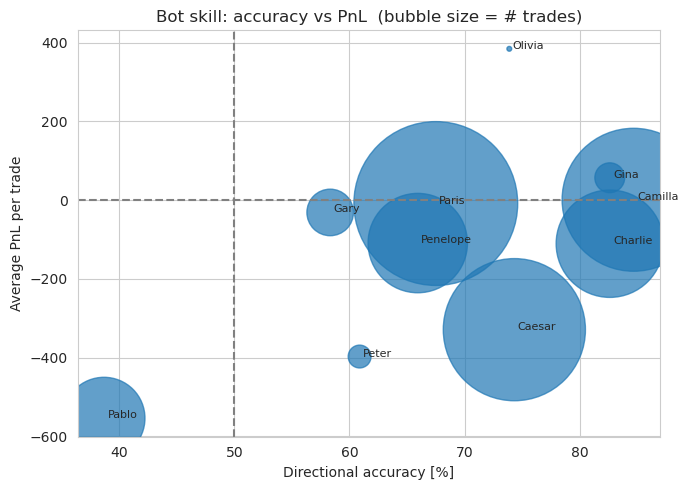

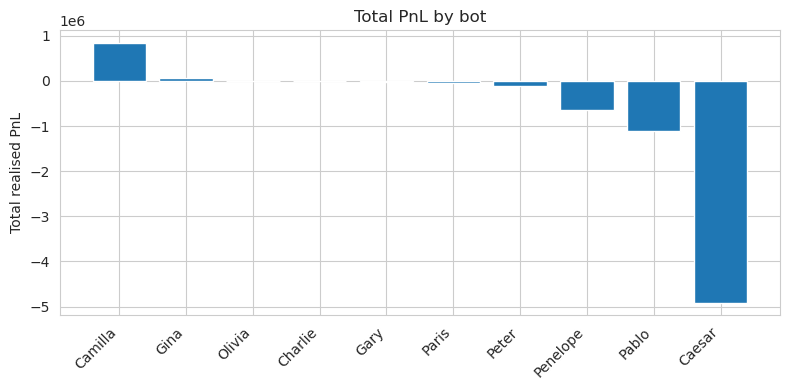

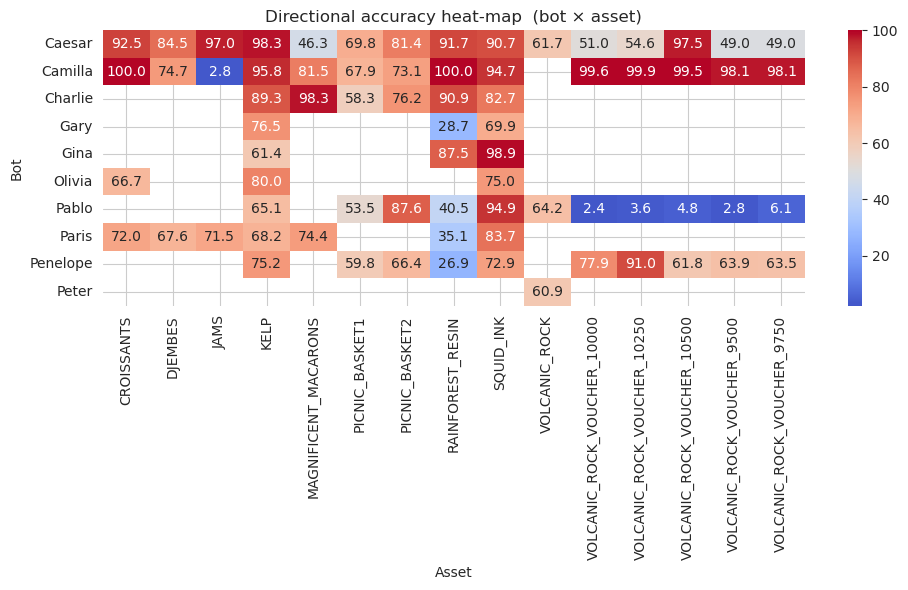

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# ─────────────────────────────────────────────────────────
# 1) Scatter: accuracy vs avg‑PnL per trade  (one point per bot)
# ─────────────────────────────────────────────────────────
bot_overall = (
    bot_asset_stats
      .groupby('aggressor_bot')
      .agg({'trades_count':'sum',
            'total_pnl':'sum',
            'avg_pnl_per_trade':'mean',
            'directional_accuracy':'mean'})
      .reset_index()
)

plt.figure(figsize=(7,5))
sizes = bot_overall['trades_count']
plt.scatter(bot_overall['directional_accuracy'],
            bot_overall['avg_pnl_per_trade'],
            s=sizes, alpha=0.7)

for _, r in bot_overall.iterrows():
    plt.text(r['directional_accuracy']+0.3,
             r['avg_pnl_per_trade']+0.02,
             r['aggressor_bot'],
             fontsize=8)

plt.axvline(50, ls='--', color='gray')   # 50 % accuracy = random
plt.axhline(0,  ls='--', color='gray')   # break‑even PnL
plt.xlabel('Directional accuracy [%]')
plt.ylabel('Average PnL per trade')
plt.title('Bot skill: accuracy vs PnL  (bubble size = # trades)')
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────
# 2) Bar chart: total PnL per bot
# ─────────────────────────────────────────────────────────
bot_sorted = bot_overall.sort_values('total_pnl', ascending=False)
plt.figure(figsize=(8,4))
plt.bar(bot_sorted['aggressor_bot'], bot_sorted['total_pnl'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total realised PnL')
plt.title('Total PnL by bot')
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────
# 3) Heat‑map: directional accuracy by (bot, asset)
# ─────────────────────────────────────────────────────────
heat = (
    bot_asset_stats
      .pivot(index='aggressor_bot', columns='asset', values='directional_accuracy')
      .sort_index()
)

plt.figure(figsize=(10,6))
sns.heatmap(heat, annot=True, fmt='.1f', cmap='coolwarm', center=50)  # 50 % is neutral (white)
plt.title('Directional accuracy heat‑map  (bot × asset)')
plt.xlabel('Asset')
plt.ylabel('Bot')
plt.tight_layout()
plt.show()


(73, 11)


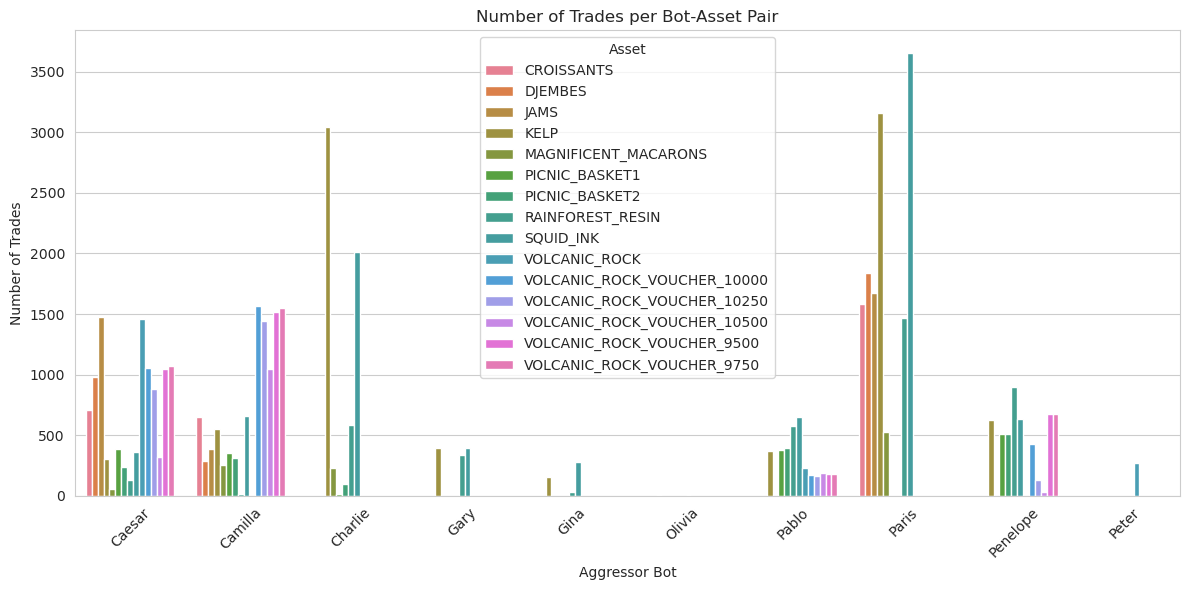

In [35]:
print(bot_asset_stats.shape)
# Save the aggregated statistics to a CSV file
bot_asset_stats.to_csv('../data/round5/bot_asset_statistics.csv', index=False, sep=';')
# Visualize the results
import seaborn as sns
import matplotlib.pyplot as plt
# Set the aesthetic style of the plots
sns.set_style("whitegrid")
# Set the size of the plots
plt.figure(figsize=(12, 6))
# Plot the number of trades per bot-asset pair
sns.barplot(data=bot_asset_stats, x='aggressor_bot', y='trades_count', hue='asset')
plt.title('Number of Trades per Bot-Asset Pair')
plt.xlabel('Aggressor Bot')
plt.ylabel('Number of Trades')
plt.xticks(rotation=45)
plt.legend(title='Asset')
plt.tight_layout()
plt.show()

In [30]:
# Prepare a correlation matrix for bots vs assets
bots = merged['aggressor_bot'].unique()
assets = merged['asset'].unique()
corr_matrix = pd.DataFrame(index=bots, columns=assets, dtype=float)

for bot in bots:
    bot_trades = merged[merged['aggressor_bot'] == bot]
    for asset in assets:
        data = bot_trades[bot_trades['asset'] == asset]
        if len(data) < 2:
            corr = None  # Not enough data to compute correlation
        else:
            # X: signed volume (positive for buy, negative for sell)
            X = np.where(data['aggressor_side'] == 'BUY', data['quantity'], -data['quantity'])
            # Y: price change (next_mid - current_mid)
            Y = data['next_mid_price'] - data['mid_price']
            # Pearson correlation
            corr = np.corrcoef(X, Y)[0, 1]  # np.corrcoef returns a 2x2 matrix
        corr_matrix.loc[bot, asset] = corr

# Display the correlation matrix
corr_matrix


,CROISSANTS,DJEMBES,JAMS,KELP,MAGNIFICENT_MACARONS,PICNIC_BASKET1,PICNIC_BASKET2,RAINFOREST_RESIN,SQUID_INK,VOLCANIC_ROCK,VOLCANIC_ROCK_VOUCHER_10000,VOLCANIC_ROCK_VOUCHER_10250,VOLCANIC_ROCK_VOUCHER_10500,VOLCANIC_ROCK_VOUCHER_9500,VOLCANIC_ROCK_VOUCHER_9750
Paris,-0.020288,NaN,NaN,0.036322,NaN,NaN,NaN,NaN,0.124265,NaN,NaN,NaN,NaN,NaN,NaN
Caesar,NaN,0.498198,0.099721,0.070595,0.182575,0.168542,0.449128,0.689842,0.079189,-0.006157,-0.052034,-0.092814,0.128865,0.026493,0.007857
Camilla,0.053516,0.000793,0.135528,0.066853,0.034196,0.177015,0.472280,0.922355,0.099307,NaN,-0.042884,-0.053334,-0.045525,-0.015333,-0.026301
Olivia,0.572856,NaN,NaN,0.604926,NaN,NaN,NaN,NaN,0.545656,NaN,NaN,NaN,NaN,NaN,NaN
None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Charlie,NaN,NaN,NaN,NaN,0.019354,0.336710,0.619330,0.707410,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Penelope,NaN,NaN,NaN,0.051422,NaN,NaN,NaN,-0.012366,0.051813,NaN,-0.141704,-0.041675,0.271145,-0.014469,-0.038437
Pablo,NaN,NaN,NaN,0.027201,NaN,0.212601,0.310205,0.188173,0.119516,0.180880,NaN,NaN,NaN,NaN,NaN
Gary,NaN,NaN,NaN,-0.022402,NaN,NaN,NaN,-0.034159,0.092981,NaN,NaN,NaN,NaN,NaN,NaN
Gina,NaN,NaN,NaN,0.039949,NaN,NaN,NaN,0.547789,0.064922,NaN,NaN,NaN,NaN,NaN,NaN


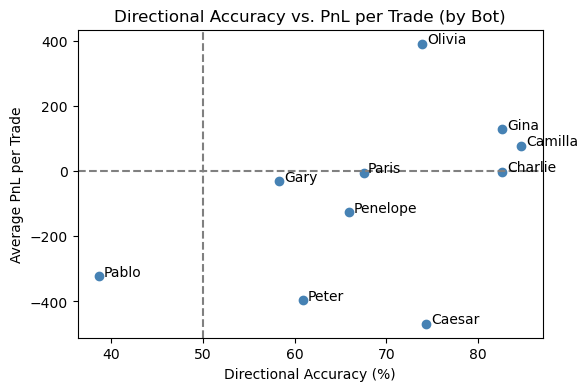

In [31]:
import matplotlib.pyplot as plt

# Suppose we aggregate per bot overall (summing PnL across assets and averaging accuracy weighted by trades):
bot_overall = bot_asset_stats.groupby('aggressor_bot').agg({
    'trades_count': 'sum',
    'total_pnl': 'sum',
    'directional_accuracy': 'mean'  # if number of trades is large per bot, a simple mean of percentages is okay here
}).reset_index()
bot_overall['avg_pnl_per_trade'] = bot_overall['total_pnl'] / bot_overall['trades_count']

# Scatter plot
plt.figure(figsize=(6,4))
plt.scatter(bot_overall['directional_accuracy'], bot_overall['avg_pnl_per_trade'], color='steelblue')
for _, row in bot_overall.iterrows():
    plt.text(row['directional_accuracy']+0.5, row['avg_pnl_per_trade']+0.01, row['aggressor_bot'])
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(50, color='gray', linestyle='--')
plt.xlabel('Directional Accuracy (%)')
plt.ylabel('Average PnL per Trade')
plt.title('Directional Accuracy vs. PnL per Trade (by Bot)')
plt.show()


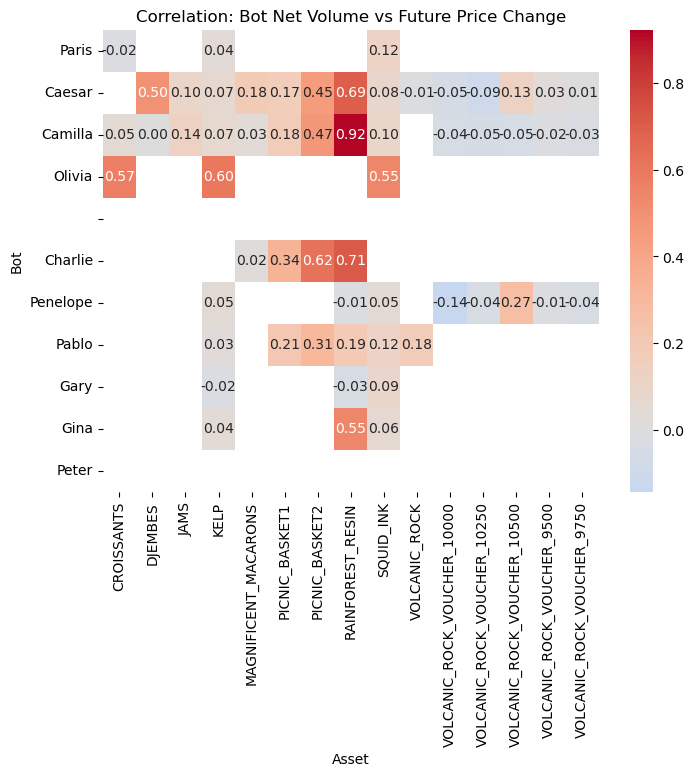

In [33]:
import seaborn as sns

# Convert correlation matrix to numeric type and replace None with NaN for heatmap
corr_matrix = corr_matrix.astype(float)

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation: Bot Net Volume vs Future Price Change")
plt.xlabel("Asset")
plt.ylabel("Bot")
plt.show()
